### MODELO PARA PREDECIR LA DEFORESTACIÓN DEL AMAZONAS EN LOS PRÓXIMOS AÑOS

En este script se realiza la ingesta y preprocesamiento de los datos y se desarrolla el modelo.

Se prueban distintos parámetros del modelo para hallar la mejor configuración de la red neuronal a partir de varios arrays que contienen distintos valores para el número de :
- n_replics: réplicas de municipios falsos que se van a generar a partir de los verdaderos
- hidden_layers: capas intermedias de la red neuronal
- epochs: épocas con las que se va a entrenar el modelo
- batch_sizes: instancias por batch de aprendizaje

In [91]:
# TODO: repensar normalizacion de train (hay q hacerlo con todos los datos por año juntos, ej: todos los incrementos de deforestacion juntos) 
# GOAL: entrenar con ventanas del conjunto de train y luago testear con distintas ventanas del conjuntos de test

In [92]:
import numpy as np 
import pandas as pd 
import math, os
from sklearn import preprocessing
import gmplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Masking, Input, Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
pd.set_option('display.max_columns', None)

In [93]:
def create_paths():
    # Creates all the necessary folders. Check if data folder already created. If not, create it
    if not os.path.exists('modelos/'):
        os.makedirs('modelos/')
    if not os.path.exists('modelos/img/'):
        os.makedirs('modelos/img/')
    if not os.path.exists('mapas/'):
        os.makedirs('mapas/')
    if not os.path.exists('resultados/'):
        os.makedirs('resultados/')

In [94]:
def obtain_data():
    dfs={}
    for i in range(19):
        year=str(2000+i)
        file='../datos/DesmatamentoMunicipios' + year + '.csv'
        dfs[i] = pd.read_csv(file, encoding = "ISO-8859-1", index_col=0, sep=",")
        #eliminamos columnas irrelevantes
        dfs[i].drop(columns='Latgms', inplace=True)
        dfs[i].drop(columns='Longms', inplace=True)
        dfs[i].drop(columns='CodIbge', inplace=True)
        #df.rename(columns={0:'Latitud', 1:'Longitud', 2:'Municipio', 3:'Estado', 4: 'AreaKm2', 5:'Deforestacion', 6:'Incremento deforestacion', 7:'Bosque', 8:'Nubes', 9:'No observado', 10:'No bosque', 11:'Hidrografia', 12:'Check'} ,inplace=True)
        dfs[i].columns=['Latitud', 'Longitud', 'Municipio', 'Estado', 'Area total', 'Deforestacion ' + year, 'Incremento deforestacion ' + year, 'Bosque ' + year, 'Nubes ' + year, 'No observado ' + year, 'No bosque', 'Hidrografia', 'Check ' + year]
        dfs[i]=dfs[i][['Latitud', 'Longitud', 'Municipio', 'Estado', 'Area total', 'No bosque', 'Hidrografia', 'Deforestacion ' + year, 'Incremento deforestacion ' + year, 'Bosque ' + year, 'Nubes ' + year, 'No observado ' + year, 'Check ' + year]]
    return dfs

In [95]:
def update_2019(df):
    file='../datos/terrabrasilis_amazon.csv'
    df_new = pd.read_csv(file, encoding = "UTF-8", sep=",")
    #limpiamos el dataset
    df_new.drop(['geocode_ibge'], axis=1, inplace=True)
    df_new = df_new.groupby(['municipality', 'state', 'year'])['areakm'].agg('sum').reset_index()
    
    estados = {
    'MATO GROSSO': 'MT', 
    'MARANHÃO': 'MA',
    'AMAPÁ': 'AP',
    'RORAIMA': 'RR',
    'AMAZONAS': 'AM',
    'PARÁ': 'PA',
    'RONDÔNIA': 'RO',
    'TOCANTINS': 'TO',
    "ACRE": "AC"
    }
    
    # Mismo formato de nombre de municipio
    for index, row in df_new.iterrows():
        df_new.iloc[index,1] = estados[row['state']]
        df_new.iloc[index,0] = row['municipality'] + " (" + str(df_new.iloc[index,1]) + ")"
        df_new
    
    # 3 casos particulares en los que el nombre tiene pequeñas diferencias entre ambos datasets
    df_new.loc[df_new['municipality']=='SANTA IZABEL DO PARÁ (PA)', 'municipality'] = 'SANTA ISABEL DO PARÁ (PA)'
    df_new.loc[df_new['municipality']=='ELDORADO DO CARAJÁS (PA)', 'municipality'] = 'ELDORADO DOS CARAJÁS (PA)'
    df_new.loc[df_new['municipality']=='POXORÉU (MT)', 'municipality'] = 'POXORÉO (MT)'
        
    # Upper del municipio para que tengan el mismo formato
    for index, row in df.iterrows():
        df.iloc[index,0] = df.iloc[index,0].upper()
        
    # Actualizamos los datos antiguos con los nuevos
    for index, row in df_new.iterrows():
        inc = 'Incremento deforestacion ' + str(row['year'])
        if row['year']==2019:
            df.loc[df['Municipio']==row['municipality'], 'Deforestacion 2019'] = df.loc[df['Municipio']==row['municipality'], 'Deforestacion 2018'] + row['areakm']
            df.loc[df['Municipio']==row['municipality'], inc] = row['areakm']
            df.loc[df['Municipio']==row['municipality'], 'Bosque 2019'] = df.loc[df['Municipio']==row['municipality'], 'Bosque 2018'] - row['areakm']
            df.loc[df['Municipio']==row['municipality'], 'Nubes 2019'] = 0
            df.loc[df['Municipio']==row['municipality'], 'No observado 2019'] = 0
            df.loc[df['Municipio']==row['municipality'], 'Check 2019'] = 100
        else:
            df.loc[df['Municipio']==row['municipality'], inc] = row['areakm']
            
    total=0
    # Si no hay dato de un municipio en 2019, asumimos que no ha habido deforestacion
    for index, row in df.iterrows():
        if math.isnan(row[-1]):
            #total+=1
            df.loc[df['Municipio']==row['Municipio'], 'Deforestacion 2019'] = row['Deforestacion 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Incremento deforestacion 2019'] = 0
            df.loc[df['Municipio']==row['Municipio'], 'Bosque 2019'] = row['Bosque 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Nubes 2019'] =  row['Nubes 2018']
            df.loc[df['Municipio']==row['Municipio'], 'No observado 2019'] = row['No observado 2018']
            df.loc[df['Municipio']==row['Municipio'], 'Check 2019'] = 100
    
    #print("--------- Municipios sin variaciones en 2019 (sus incrementos del año anterior son <5km^2, así que tiene sentido):", total)
    
    return df

In [96]:
def create_df(dfs):
    df=dfs[0]
    dic={}
    for idx, row in df.iterrows():
            if row['Municipio'] in dic:
                dic[row['Municipio']]+=1
            else:
                dic[row['Municipio']]=1

    repetidos=[]
    for key, value in dic.items():
        if value==2:
            repetidos.append(key)

    rep= df.Municipio.isin(repetidos)
    mismo_municipio =  df[rep]
    #print("Hay algunos municipios con el mismo nombre en 2 estados distintos:")
    #print(mismo_municipio.loc[:,'Latitud':'Area total'])

    df=dfs[0]
    for idx, value in dfs.items():
        value['Municipio']=value['Municipio'] + " (" + value['Estado'] + ")"
        if idx > 0:
            value.drop(columns='Latitud', inplace=True)
            value.drop(columns='Longitud', inplace=True)
            value.drop(columns='Estado', inplace=True)
            value.drop(columns='Area total', inplace=True)
            value.drop(columns='Hidrografia', inplace=True)
            value.drop(columns='No bosque', inplace=True)
            df=pd.merge(df, value, on='Municipio')

    # reorder columns
    cols = df.columns.tolist()
    cols = cols[2:4] + cols[0:2] + cols[4:]
    df = df[cols]
    
    df = update_2019(df)
    return df

In [97]:
def shuffle_df(df):
    # El dataset viene ordenado por deforestacion, de mayor a menor. Para entrenar el modelo alteramos el orden de forma aleatoria."
    df = df.sample(frac=1)
    df.reset_index(inplace=True, drop=True)
    df.head()
    return df

In [98]:
def plot_map(df, name):
    print("Dibujamos el mapa de " + str(len(df['Latitud'])) + " municipios")
    gmap = gmplot.GoogleMapPlotter(df['Latitud'].values[0], df['Longitud'].values[0], 5) # coordenadas del primer municipio del dataframe
    gmap.heatmap(df['Latitud'], df['Longitud']) 
    gmap.draw(name)
    print("Mapa de calor generado")

In [99]:
def generate_fake_data(df, n_replic):
    if n_replic < 1:
        return
    fake_data=[]
    std=df.std()
    #print(std)
    for idx, row in df.iterrows():
        for i in range(n_replic):
            munic = row['Municipio']+' fake_'+str(i)
            estado = row['Estado']
            lat = row['Latitud']+std['Latitud']*0.1*np.random.uniform(-1,1) # variacion del 10% de la desviación típica
            long = row['Longitud']+std['Longitud']*0.1*np.random.uniform(-1,1) # variacion del 10% de la desviación típica
            area = row['Area total']+row['Area total']*0.5*np.random.uniform(-1,1) # variacion del 50% del valor real
            no_bosq = row['No bosque']+row['No bosque']*0.5*np.random.uniform(-1,1) # variacion del 10% del valor real
            hidro = row['Hidrografia']+row['Hidrografia']*0.5*np.random.uniform(-1,1) # variacion del 10% del valor real
            temp = []
            for j in range(20):    #TODO: Normalizar por año y append todas a la vez, no se puede cambiar el area cada año
                #year = 2000 + j
                if len(temp) > 5:
                    incr = row[n_vars_temp*j+8]   # 7 vars fijas + 1 defor para llegar al incremento
                    proporcion = incr/row['Area total']
                    t = area*proporcion
                    incr = t+t*0.05*np.random.uniform(-1,1)
                    defor = temp[-6] + incr
                    bosque = temp[-4] - incr
                    temp.extend([defor,incr, bosque])
                else:
                    proporcion = row[j+7]/row['Area total']
                    t = area*proporcion
                    defor = t+t*0.05*np.random.uniform(0,1)
                    bosque = area - (defor + no_bosq + hidro)
                    temp.extend([defor,float('NaN'), bosque])
                nubes = 0
                no_obs = 0
                suma = defor + no_bosq + hidro + bosque + nubes + no_obs
                check = suma/area*100
                temp.extend([nubes, no_obs, check])
            fixed = [munic, estado, lat, long, area, no_bosq, hidro]     
            fake_row = np.concatenate((fixed, temp))
            fake_data.append(fake_row)
    fake_df = pd.DataFrame(fake_data, columns=df.columns)
    fake_df = fake_df.infer_objects()
    return fake_df



In [100]:
def series_to_supervised(temporal_vars, year_ini_train=0, window_size=3, n_vars_temp=6):
    # ensure all data is float
    temporal_vars = temporal_vars.astype('float32')
    temporal_train = temporal_vars.iloc[:, n_vars_temp*year_ini_train:-window_size*n_vars_temp]
    temporal_test = temporal_vars.iloc[:, -window_size*n_vars_temp:]
    return temporal_train, temporal_test

In [101]:
def preprocess_train(temporal_train, fixed_vars, n_vars_temp, window_size):
    # structure for normalization
    data=[]
    municipios=temporal_train.shape[0]
    len_columns=temporal_train.shape[1]
    for idx, row in temporal_train.iterrows():
        i=0
        while (i+1)*n_vars_temp <= len_columns:
            data.append(row[i*n_vars_temp:(i+1)*n_vars_temp].values)
            i+=1
    reshaped_train = pd.DataFrame(data)
    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(reshaped_train)
    x = pd.DataFrame(x)
    x = x.fillna(-1)
    #x = x.values
    
    # structure for lstm
    y = []
    vars_lstm = []
    years = int(len_columns/n_vars_temp)
    for j in range(municipios):
        x_mun=x.iloc[j*years:(j+1)*years,:]
        k=0
        while k+window_size <= years:
            municipio=x_mun.iloc[k:k+window_size-1,:].values
            vars_lstm.append(municipio)
            y.append(x_mun.iloc[k+window_size-1,1])
            k+=1

    X1 = np.array(vars_lstm)
    y = np.array(y)

    # data structure for Dense
    # One hot encoding 
    fixed_vars = pd.concat([fixed_vars,pd.get_dummies(fixed_vars['Estado'])],axis=1)
    # Drop column as it is now encoded
    fixed_vars = fixed_vars.drop('Estado',axis = 1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    x = scaler2.fit_transform(fixed_vars.iloc[:,1:]) # nombre del municipio en la primera columna
    fixed_vars = pd.DataFrame(x)
    # append the fixed information as many times as windows we have
    X2 = []
    for idx, row in fixed_vars.iterrows():
        k=0
        while k+window_size <= years:
            X2.append(row.values)
            k+=1
    X2 = np.array(X2)
    
    return X1, X2, y, scaler, scaler2

In [102]:
def create_model(window_size, n_vars_temp, hidden_layers, mask=1):
    # LSTM para variables temporales
    input_temporal = Input(shape=(window_size-1, n_vars_temp))
    if mask==0:
        lstm = LSTM(5, activation='relu')(input_temporal) #, unroll =True) -> check what it is
    else:
        masking = Masking(mask_value=-1)(input_temporal)
        lstm = LSTM(5, activation='relu', dropout=0.2)(masking)
    dense_1 = Dense(16, activation = 'relu')(lstm)
    
    # Dense para variables fijas
    input_fijo = Input(shape=(X2_train.shape[1],))
    dense_2 = Dense(32, activation = 'relu')(input_fijo)
    
    # concateno las 2 redes
    merge = concatenate([dense_1, dense_2])
    dense = [merge]
    for i in range(hidden_layers):
        dense.append(Dense(16, activation = 'relu')(dense[-1]))
    output = Dense(1, activation = 'relu')(dense[-1])
    model = Model(inputs=[input_temporal, input_fijo], outputs=output)
    
    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='modelos/img/model_'+str(hidden_layers)+'.png')
    return model

In [103]:
def preprocess_test(temporal_test, X2_train, n_vars_temp, scaler, scaler2):
    # structure for normalization
    data=[]
    municipios=temporal_test.shape[0]
    len_columns=temporal_test.shape[1]
    for idx, row in temporal_test.iterrows():
        i=0
        while (i+1)*n_vars_temp <= len_columns:
            data.append(row[i*n_vars_temp:(i+1)*n_vars_temp].values)
            i+=1
    reshaped_train = pd.DataFrame(data)
    # normalization using the scaler we used for train
    x = scaler.fit_transform(reshaped_train)
    x = pd.DataFrame(x)
    x = x.fillna(-1)
    #x = x.values
    
    # structure for lstm
    y = []
    vars_lstm = []
    years = int(len_columns/n_vars_temp)
    for j in range(municipios):
        x_mun=x.iloc[j*years:(j+1)*years,:]
        k=0
        while k+window_size <= years:
            municipio=x_mun.iloc[k:k+window_size-1,:].values
            vars_lstm.append(municipio)
            y.append(x_mun.iloc[k+window_size-1,1])
            k+=1

    X1 = np.array(vars_lstm)
    y = np.array(y)   

    # data structure for Dense: same as train with same order, but (maybe) different length
    X2 = X2_train[:len(X1)]
    
    
    return X1, X2, y

In [104]:
def evaluate_test(municipios, y, y_pred):
    # rescaling
    to_rescale = []
    for elem in y:
        to_rescale.append([0,elem,0,0,0,0])
    to_rescale = pd.DataFrame(to_rescale)
    y=scaler.inverse_transform(to_rescale)
    y=pd.DataFrame(y).iloc[:,1].values
    to_rescale = []
    for elem in y_pred:
        to_rescale.append([0,elem,0,0,0,0])
    to_rescale = pd.DataFrame(to_rescale)
    y_pred=scaler.inverse_transform(to_rescale)
    y_pred=pd.DataFrame(y_pred).iloc[:,1].values
    print(len(municipios.values.flatten()), len(y), len(y_pred))
    
    errores = []
    abajo = 0
    num_test = len(y_pred)
    for i in range(num_test):
        delta = y[i] - y_pred[i]
        if delta > 0:
            abajo += 1
        error = abs(delta)
        #print(municipios_reales[i], 'Expected', y[i], 'Predicted', y_pred[i], 'Error', str(error))
        errores.append(error)
    test = {'Municipio': municipios.values.flatten(), 'Expected': y, 'Predicted': y_pred, 'Error': errores}
    test = pd.DataFrame(test)
    print('Error absoluto medio', np.array(errores).mean(), "con una muestra de", num_test, "municipios")
    print('La predicción es menor que el dato real',abajo, "veces")
    print(test)
    return test

In [105]:
create_paths()

dfs = obtain_data()
df = create_df(dfs)
df.to_csv('../datos/datos_reales.csv')

print("\nEl area total cubierta por los municipios es: " + str(df.sum(axis = 0, skipna = True)[4]) + " km^2, mientras el area total de la Amazonia es de 5,5M km^2.")
print("Por ello, podemos afirmar que estamos cubriendo una superficie que supone el 92% del total.\n")

plot_map(df, 'mapas/mapa.html')

n_vars_temp = df.loc[:,'Deforestacion 2000':].shape[1]//20 # number of variables per year

#shuffle data
df = shuffle_df(df)


El area total cubierta por los municipios es: 5068048 km^2, mientras el area total de la Amazonia es de 5,5M km^2.
Por ello, podemos afirmar que estamos cubriendo una superficie que supone el 92% del total.

Dibujamos el mapa de 760 municipios
Mapa de calor generado


In [106]:
results = []
n_replics = [0,5,20,50]
for n in n_replics:
    if n == 0:
        df_complete = df
    else:
        fake_df = generate_fake_data(df, n)
        df_complete = df.append(fake_df)
    #df_complete = df_complete.sort_values(by=['Municipio']) # to be ommited for the test: 760 primeros municipios son los reales
    df_complete.loc[:,'Latitud':] = df_complete.loc[:,'Latitud':].astype('float')
    df_complete = df_complete.infer_objects()
    print("Datos obtenidos")
    
    #plot map
    name = 'mapa_fake' + str(n) + '.html'
    plot_map(df_complete, "mapas/" + name)

    #shuffle data
    df_complete[760:] = shuffle_df(df_complete[760:])
    
    # structure data
    fixed_vars = df_complete.loc[:,['Municipio', 'Estado', 'Latitud', 'Longitud', 'Area total', 'Hidrografia', 'No bosque']]
    temporal_vars = df_complete.loc[:,'Deforestacion 2000':]
    window_size=4
    temporal_train, temporal_test = series_to_supervised(temporal_vars, 0, window_size, n_vars_temp)
    temporal_train, temporal_valid = series_to_supervised(temporal_train, 0, window_size, n_vars_temp)
    #print(temporal_vars.head(), "\n", temporal_train.head(), "\n", temporal_valid.head(), "\n", temporal_test.head())
    
    # preprocess data for training and validation
    X1_train, X2_train, y_train, scaler, scaler2 = preprocess_train(temporal_train, fixed_vars, n_vars_temp, window_size)
    print("Train:", X1_train.shape, X2_train.shape, y_train.shape)
    X1_valid, X2_valid, y_valid = preprocess_test(temporal_valid, X2_train, n_vars_temp, scaler, scaler2)
    print("Validation:", X1_valid.shape, X2_valid.shape, y_valid.shape)
    # preprocess data for testing
    X1_test, X2_test, y_test = preprocess_test(temporal_test, X2_train, n_vars_temp, scaler, scaler2)
    print("Test:", X1_test.shape, X2_test.shape, y_test.shape)
    municipios_reales = fixed_vars.iloc[0:760,0]
    print("Datos preprocesados")
                
    # create model
    hidden_layers=[1,2,3]
    epochs=[5,10,50,100]
    batch_sizes=[32,64]
    for h in hidden_layers:
        for e in epochs:
            for bs in batch_sizes:
                print("Creando el modelo...")
                print('\tCapas intermedias', h)
                print("\tNúmero de épocas:", e)
                print('\tBatch size:', bs)
                print('\tMuestra para training:', len(df_complete), 'municipios')
                model_name = "model_" + str(h) + "_" + str(e) + "_" + str(bs) + "_" + str(n) + ".h5"
                model = create_model(window_size, n_vars_temp, h)
                model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
                # fit model
                checkpoint_cb = ModelCheckpoint("modelos/" + model_name, save_best_only=True, verbose=1)
                model.fit([X1_train, X2_train], y_train, epochs=e, batch_size=bs, verbose=2, validation_data=([X1_valid, X2_valid], y_valid), callbacks=[checkpoint_cb])

                # evaluate model on validation data
                model = load_model("modelos/" + model_name)
                y_pred = model.predict([X1_valid, X2_valid])
                test = evaluate_test(fixed_vars[['Municipio']], y_valid, y_pred)

                d = {}
                d['Municipios'] = len(df_complete)
                d['Epocas'] = e
                d['Batch size'] = bs
                d['Capas intermedias'] = h
                d['Error absoluto medio'] = test['Error'].mean()
                results.append(d)

df_results = pd.DataFrame(results)
df_results.to_excel('resultados/precision_configuraciones_modelo.xlsx') # results of the different configurations

Datos obtenidos
Dibujamos el mapa de 760 municipios
Mapa de calor generado
Train: (6840, 3, 6) (6840, 14) (6840,)
Validation: (760, 3, 6) (760, 14) (760,)
Test: (760, 3, 6) (760, 14) (760,)
Datos preprocesados
Creando el modelo...
	Capas intermedias 1
	Número de épocas: 5
	Batch size: 32
	Muestra para training: 760 municipios
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_9 (Masking)             (None, 3, 6)         0           input_17[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 5)            240     

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_11 (Masking)            (None, 3, 6)         0           input_21[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 5)            240         masking_11[0][0]                 
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 14)           0                                            
___________________________________________________________________________________________

 - 0s - loss: 6.2538e-04 - mae: 0.0090 - val_loss: 0.0061 - val_mae: 0.0253

Epoch 00006: val_loss improved from 0.00647 to 0.00606, saving model to modelos/model_1_10_64_0.h5
Epoch 7/10
 - 0s - loss: 6.3799e-04 - mae: 0.0089 - val_loss: 0.0063 - val_mae: 0.0253

Epoch 00007: val_loss did not improve from 0.00606
Epoch 8/10
 - 0s - loss: 6.6316e-04 - mae: 0.0089 - val_loss: 0.0066 - val_mae: 0.0249

Epoch 00008: val_loss did not improve from 0.00606
Epoch 9/10
 - 0s - loss: 5.9793e-04 - mae: 0.0087 - val_loss: 0.0062 - val_mae: 0.0246

Epoch 00009: val_loss did not improve from 0.00606
Epoch 10/10
 - 0s - loss: 6.6295e-04 - mae: 0.0089 - val_loss: 0.0067 - val_mae: 0.0251

Epoch 00010: val_loss did not improve from 0.00606
760 760 760
Error absoluto medio 14.571720466861285 con una muestra de 760 municipios
La predicción es menor que el dato real 450 veces
                        Municipio   Expected  Predicted      Error
0                    JUARINA (TO)   0.000000   0.000000   0.0000

 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00030: val_loss did not improve from 0.00799
Epoch 31/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00031: val_loss did not improve from 0.00799
Epoch 32/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00032: val_loss did not improve from 0.00799
Epoch 33/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00033: val_loss did not improve from 0.00799
Epoch 34/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00034: val_loss did not improve from 0.00799
Epoch 35/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00035: val_loss did not improve from 0.00799
Epoch 36/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00036: val_loss did not improve from 0.00799
Epoch 37/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0


Epoch 00011: val_loss improved from 0.00685 to 0.00682, saving model to modelos/model_1_50_64_0.h5
Epoch 12/50
 - 1s - loss: 7.4460e-04 - mae: 0.0092 - val_loss: 0.0066 - val_mae: 0.0249

Epoch 00012: val_loss improved from 0.00682 to 0.00656, saving model to modelos/model_1_50_64_0.h5
Epoch 13/50
 - 1s - loss: 7.5670e-04 - mae: 0.0091 - val_loss: 0.0068 - val_mae: 0.0256

Epoch 00013: val_loss did not improve from 0.00656
Epoch 14/50
 - 1s - loss: 7.8605e-04 - mae: 0.0095 - val_loss: 0.0067 - val_mae: 0.0245

Epoch 00014: val_loss did not improve from 0.00656
Epoch 15/50
 - 1s - loss: 7.4143e-04 - mae: 0.0090 - val_loss: 0.0066 - val_mae: 0.0269

Epoch 00015: val_loss did not improve from 0.00656
Epoch 16/50
 - 1s - loss: 6.8463e-04 - mae: 0.0089 - val_loss: 0.0068 - val_mae: 0.0253

Epoch 00016: val_loss did not improve from 0.00656
Epoch 17/50
 - 1s - loss: 7.2699e-04 - mae: 0.0092 - val_loss: 0.0066 - val_mae: 0.0261

Epoch 00017: val_loss did not improve from 0.00656
Epoch 18/50


Train on 6840 samples, validate on 760 samples
Epoch 1/100
 - 3s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_1_100_32_0.h5
Epoch 2/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 0


Epoch 00060: val_loss did not improve from 0.00799
Epoch 61/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00061: val_loss did not improve from 0.00799
Epoch 62/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00062: val_loss did not improve from 0.00799
Epoch 63/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00063: val_loss did not improve from 0.00799
Epoch 64/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00064: val_loss did not improve from 0.00799
Epoch 65/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00065: val_loss did not improve from 0.00799
Epoch 66/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00066: val_loss did not improve from 0.00799
Epoch 67/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00067: val_loss did not improve fr

Train on 6840 samples, validate on 760 samples
Epoch 1/100
 - 3s - loss: 0.0056 - mae: 0.0335 - val_loss: 0.0080 - val_mae: 0.0260

Epoch 00001: val_loss improved from inf to 0.00797, saving model to modelos/model_1_100_64_0.h5
Epoch 2/100
 - 1s - loss: 0.0013 - mae: 0.0110 - val_loss: 0.0078 - val_mae: 0.0273

Epoch 00002: val_loss improved from 0.00797 to 0.00778, saving model to modelos/model_1_100_64_0.h5
Epoch 3/100
 - 1s - loss: 9.6817e-04 - mae: 0.0106 - val_loss: 0.0074 - val_mae: 0.0260

Epoch 00003: val_loss improved from 0.00778 to 0.00741, saving model to modelos/model_1_100_64_0.h5
Epoch 4/100
 - 1s - loss: 8.3657e-04 - mae: 0.0095 - val_loss: 0.0068 - val_mae: 0.0252

Epoch 00004: val_loss improved from 0.00741 to 0.00681, saving model to modelos/model_1_100_64_0.h5
Epoch 5/100
 - 1s - loss: 8.2345e-04 - mae: 0.0092 - val_loss: 0.0062 - val_mae: 0.0251

Epoch 00005: val_loss improved from 0.00681 to 0.00617, saving model to modelos/model_1_100_64_0.h5
Epoch 6/100
 - 1s - 

 - 1s - loss: 4.1258e-04 - mae: 0.0073 - val_loss: 0.0053 - val_mae: 0.0249

Epoch 00054: val_loss did not improve from 0.00480
Epoch 55/100
 - 1s - loss: 4.5568e-04 - mae: 0.0075 - val_loss: 0.0052 - val_mae: 0.0239

Epoch 00055: val_loss did not improve from 0.00480
Epoch 56/100
 - 1s - loss: 4.5233e-04 - mae: 0.0075 - val_loss: 0.0054 - val_mae: 0.0237

Epoch 00056: val_loss did not improve from 0.00480
Epoch 57/100
 - 1s - loss: 5.1197e-04 - mae: 0.0078 - val_loss: 0.0051 - val_mae: 0.0237

Epoch 00057: val_loss did not improve from 0.00480
Epoch 58/100
 - 1s - loss: 3.9187e-04 - mae: 0.0072 - val_loss: 0.0053 - val_mae: 0.0246

Epoch 00058: val_loss did not improve from 0.00480
Epoch 59/100
 - 1s - loss: 4.5652e-04 - mae: 0.0074 - val_loss: 0.0054 - val_mae: 0.0245

Epoch 00059: val_loss did not improve from 0.00480
Epoch 60/100
 - 1s - loss: 4.1579e-04 - mae: 0.0074 - val_loss: 0.0051 - val_mae: 0.0239

Epoch 00060: val_loss did not improve from 0.00480
Epoch 61/100
 - 1s - loss:

Train on 6840 samples, validate on 760 samples
Epoch 1/5
 - 3s - loss: 0.0031 - mae: 0.0193 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_2_5_32_0.h5
Epoch 2/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
760 760 760
Error absoluto medio 14.875523854998164 con una muestra de 760 municipios
La predicción es menor que el dato real 528 veces
                        Municipio   Expected  Predicted      Error
0                    JUARINA (TO)   0

Train on 6840 samples, validate on 760 samples
Epoch 1/10
 - 3s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_2_10_32_0.h5
Epoch 2/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00007: va

Train on 6840 samples, validate on 760 samples
Epoch 1/50
 - 4s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_2_50_32_0.h5
Epoch 2/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00007: va

Train on 6840 samples, validate on 760 samples
Epoch 1/50
 - 3s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_2_50_64_0.h5
Epoch 2/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/50
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00007: va

Train on 6840 samples, validate on 760 samples
Epoch 1/100
 - 4s - loss: 0.0014 - mae: 0.0111 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_2_100_32_0.h5
Epoch 2/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 0


Epoch 00060: val_loss did not improve from 0.00799
Epoch 61/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00061: val_loss did not improve from 0.00799
Epoch 62/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00062: val_loss did not improve from 0.00799
Epoch 63/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00063: val_loss did not improve from 0.00799
Epoch 64/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00064: val_loss did not improve from 0.00799
Epoch 65/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00065: val_loss did not improve from 0.00799
Epoch 66/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00066: val_loss did not improve from 0.00799
Epoch 67/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00067: val_loss did not improve fr

Train on 6840 samples, validate on 760 samples
Epoch 1/100
 - 4s - loss: 0.0010 - mae: 0.0121 - val_loss: 0.0070 - val_mae: 0.0279

Epoch 00001: val_loss improved from inf to 0.00697, saving model to modelos/model_2_100_64_0.h5
Epoch 2/100
 - 1s - loss: 6.8096e-04 - mae: 0.0098 - val_loss: 0.0055 - val_mae: 0.0237

Epoch 00002: val_loss improved from 0.00697 to 0.00553, saving model to modelos/model_2_100_64_0.h5
Epoch 3/100
 - 1s - loss: 5.9328e-04 - mae: 0.0092 - val_loss: 0.0057 - val_mae: 0.0234

Epoch 00003: val_loss did not improve from 0.00553
Epoch 4/100
 - 1s - loss: 6.3259e-04 - mae: 0.0089 - val_loss: 0.0054 - val_mae: 0.0225

Epoch 00004: val_loss improved from 0.00553 to 0.00540, saving model to modelos/model_2_100_64_0.h5
Epoch 5/100
 - 1s - loss: 5.4580e-04 - mae: 0.0085 - val_loss: 0.0054 - val_mae: 0.0228

Epoch 00005: val_loss improved from 0.00540 to 0.00539, saving model to modelos/model_2_100_64_0.h5
Epoch 6/100
 - 1s - loss: 5.8016e-04 - mae: 0.0087 - val_loss: 0.


Epoch 00056: val_loss did not improve from 0.00511
Epoch 57/100
 - 1s - loss: 3.9487e-04 - mae: 0.0073 - val_loss: 0.0053 - val_mae: 0.0223

Epoch 00057: val_loss did not improve from 0.00511
Epoch 58/100
 - 1s - loss: 4.5801e-04 - mae: 0.0076 - val_loss: 0.0052 - val_mae: 0.0228

Epoch 00058: val_loss did not improve from 0.00511
Epoch 59/100
 - 1s - loss: 4.8323e-04 - mae: 0.0080 - val_loss: 0.0053 - val_mae: 0.0232

Epoch 00059: val_loss did not improve from 0.00511
Epoch 60/100
 - 1s - loss: 4.3869e-04 - mae: 0.0076 - val_loss: 0.0053 - val_mae: 0.0227

Epoch 00060: val_loss did not improve from 0.00511
Epoch 61/100
 - 1s - loss: 4.2730e-04 - mae: 0.0074 - val_loss: 0.0053 - val_mae: 0.0226

Epoch 00061: val_loss did not improve from 0.00511
Epoch 62/100
 - 1s - loss: 4.1171e-04 - mae: 0.0075 - val_loss: 0.0052 - val_mae: 0.0229

Epoch 00062: val_loss did not improve from 0.00511
Epoch 63/100
 - 1s - loss: 4.5337e-04 - mae: 0.0074 - val_loss: 0.0052 - val_mae: 0.0223

Epoch 00063:

Train on 6840 samples, validate on 760 samples
Epoch 1/5
 - 4s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_3_5_32_0.h5
Epoch 2/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/5
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
760 760 760
Error absoluto medio 14.875523854998164 con una muestra de 760 municipios
La predicción es menor que el dato real 528 veces
                        Municipio   Expected  Predicted      Error
0                    JUARINA (TO)   0

Train on 6840 samples, validate on 760 samples
Epoch 1/10
 - 5s - loss: 0.0024 - mae: 0.0169 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_3_10_32_0.h5
Epoch 2/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss improved from 0.00799 to 0.00799, saving model to modelos/model_3_10_32_0.h5
Epoch 3/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss improved from 0.00799 to 0.00799, saving model to modelos/model_3_10_32_0.h5
Epoch 4/10
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss improved from 0.00799 to 0.00799, saving model to modelos/model_3_10_32_0.h5
Epoch 5/10
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss improved from 0.00799 to 0.00799, saving model to modelos/model_3_10_32_0.h5
Epoch 6/10
 - 2s - loss: 0.0014 - mae: 0.0

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_29 (Masking)            (None, 3, 6)         0           input_57[0][0]                   
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 5)            240         masking_29[0][0]                 
__________________________________________________________________________________________________
input_58 (InputLayer)           (None, 14)           0                                            
___________________________________________________________________________________________


Epoch 00040: val_loss did not improve from 0.00799
Epoch 41/50
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00041: val_loss did not improve from 0.00799
Epoch 42/50
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00042: val_loss did not improve from 0.00799
Epoch 43/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00043: val_loss did not improve from 0.00799
Epoch 44/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00044: val_loss did not improve from 0.00799
Epoch 45/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00045: val_loss did not improve from 0.00799
Epoch 46/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00046: val_loss did not improve from 0.00799
Epoch 47/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00047: val_loss did not improve from 0.00

 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00022: val_loss did not improve from 0.00799
Epoch 23/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00023: val_loss did not improve from 0.00799
Epoch 24/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00024: val_loss did not improve from 0.00799
Epoch 25/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00025: val_loss did not improve from 0.00799
Epoch 26/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00026: val_loss did not improve from 0.00799
Epoch 27/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00027: val_loss did not improve from 0.00799
Epoch 28/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00028: val_loss did not improve from 0.00799
Epoch 29/50
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0


Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00007: val_loss did not improve from 0.00799
Epoch 8/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00008: val_loss did not improve from 0.00799
Epoch 9/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00009: val_loss did not improve from 0.00799
Epoch 10/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00010: val_loss did not improve from 0.0


Epoch 00063: val_loss did not improve from 0.00799
Epoch 64/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00064: val_loss did not improve from 0.00799
Epoch 65/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00065: val_loss did not improve from 0.00799
Epoch 66/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00066: val_loss did not improve from 0.00799
Epoch 67/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00067: val_loss did not improve from 0.00799
Epoch 68/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00068: val_loss did not improve from 0.00799
Epoch 69/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00069: val_loss did not improve from 0.00799
Epoch 70/100
 - 2s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00070: val_loss did not improve fr

Train on 6840 samples, validate on 760 samples
Epoch 1/100
 - 5s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00001: val_loss improved from inf to 0.00799, saving model to modelos/model_3_100_64_0.h5
Epoch 2/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00002: val_loss did not improve from 0.00799
Epoch 3/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00003: val_loss did not improve from 0.00799
Epoch 4/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00004: val_loss did not improve from 0.00799
Epoch 5/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00005: val_loss did not improve from 0.00799
Epoch 6/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00006: val_loss did not improve from 0.00799
Epoch 7/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 0


Epoch 00060: val_loss did not improve from 0.00799
Epoch 61/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00061: val_loss did not improve from 0.00799
Epoch 62/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00062: val_loss did not improve from 0.00799
Epoch 63/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00063: val_loss did not improve from 0.00799
Epoch 64/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00064: val_loss did not improve from 0.00799
Epoch 65/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00065: val_loss did not improve from 0.00799
Epoch 66/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00066: val_loss did not improve from 0.00799
Epoch 67/100
 - 1s - loss: 0.0014 - mae: 0.0109 - val_loss: 0.0080 - val_mae: 0.0259

Epoch 00067: val_loss did not improve fr

Train on 41040 samples, validate on 4560 samples
Epoch 1/5
 - 15s - loss: 7.8609e-04 - mae: 0.0084 - val_loss: 0.0050 - val_mae: 0.0207

Epoch 00001: val_loss improved from inf to 0.00501, saving model to modelos/model_1_5_32_5.h5
Epoch 2/5
 - 10s - loss: 5.9623e-04 - mae: 0.0072 - val_loss: 0.0050 - val_mae: 0.0207

Epoch 00002: val_loss did not improve from 0.00501
Epoch 3/5
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0050 - val_mae: 0.0207

Epoch 00003: val_loss did not improve from 0.00501
Epoch 4/5
 - 9s - loss: 5.9676e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00501
Epoch 5/5
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00501
4560 4560 4560
Error absoluto medio 13.292901052618722 con una muestra de 4560 municipios
La predicción es menor que el dato real 3168 veces
                                     Municipio   Expected  Predicted  \
0  

Train on 41040 samples, validate on 4560 samples
Epoch 1/10
 - 16s - loss: 6.0590e-04 - mae: 0.0073 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_1_10_32_5.h5
Epoch 2/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/10
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/10
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.00

Train on 41040 samples, validate on 4560 samples
Epoch 1/50
 - 14s - loss: 6.3718e-04 - mae: 0.0075 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_1_50_32_5.h5
Epoch 2/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.00

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_38 (Masking)            (None, 3, 6)         0           input_75[0][0]                   
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 5)            240         masking_38[0][0]                 
__________________________________________________________________________________________________
input_76 (InputLayer)           (None, 14)           0                                            
___________________________________________________________________________________________

 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00042: val_loss did not improve from 0.00509
Epoch 43/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00043: val_loss did not improve from 0.00509
Epoch 44/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00044: val_loss did not improve from 0.00509
Epoch 45/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00045: val_loss did not improve from 0.00509
Epoch 46/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00046: val_loss did not improve from 0.00509
Epoch 47/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00047: val_loss did not improve from 0.00509
Epoch 48/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00048: val_loss did not improve from 0.00509
Epoch 49/50
 - 5s - loss: 5.9627

 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00023: val_loss did not improve from 0.00509
Epoch 24/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00024: val_loss did not improve from 0.00509
Epoch 25/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00025: val_loss did not improve from 0.00509
Epoch 26/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00026: val_loss did not improve from 0.00509
Epoch 27/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00027: val_loss did not improve from 0.00509
Epoch 28/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00028: val_loss did not improve from 0.00509
Epoch 29/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00029: val_loss did not improve from 0.00509
Epoch 30/100
 - 10s

 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00081: val_loss did not improve from 0.00509
Epoch 82/100
 - 15s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00082: val_loss did not improve from 0.00509
Epoch 83/100
 - 14s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00083: val_loss did not improve from 0.00509
Epoch 84/100
 - 15s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00084: val_loss did not improve from 0.00509
Epoch 85/100
 - 13s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00085: val_loss did not improve from 0.00509
Epoch 86/100
 - 13s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00086: val_loss did not improve from 0.00509
Epoch 87/100
 - 13s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00087: val_loss did not improve from 0.00509
Epoch 88/100
 - 13s

 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00012: val_loss did not improve from 0.00509
Epoch 13/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00013: val_loss did not improve from 0.00509
Epoch 14/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00014: val_loss did not improve from 0.00509
Epoch 15/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00015: val_loss did not improve from 0.00509
Epoch 16/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00016: val_loss did not improve from 0.00509
Epoch 17/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00017: val_loss did not improve from 0.00509
Epoch 18/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00018: val_loss did not improve from 0.00509
Epoch 19/100
 - 6s - loss:


Epoch 00070: val_loss did not improve from 0.00509
Epoch 71/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00071: val_loss did not improve from 0.00509
Epoch 72/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00072: val_loss did not improve from 0.00509
Epoch 73/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00073: val_loss did not improve from 0.00509
Epoch 74/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00074: val_loss did not improve from 0.00509
Epoch 75/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00075: val_loss did not improve from 0.00509
Epoch 76/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00076: val_loss did not improve from 0.00509
Epoch 77/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00077:

Train on 41040 samples, validate on 4560 samples
Epoch 1/5
 - 18s - loss: 6.0058e-04 - mae: 0.0073 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_2_5_32_5.h5
Epoch 2/5
 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/5
 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/5
 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/5
 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
4560 4560 4560
Error absoluto medio 13.328882230529212 con una muestra de 4560 municipios
La predicción es menor que el dato real 3168 veces
                                     Municipio   Expected  Predicted  \


Train on 41040 samples, validate on 4560 samples
Epoch 1/10
 - 14s - loss: 4.3303e-04 - mae: 0.0068 - val_loss: 0.0050 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00496, saving model to modelos/model_2_10_32_5.h5
Epoch 2/10
 - 9s - loss: 3.7112e-04 - mae: 0.0065 - val_loss: 0.0047 - val_mae: 0.0205

Epoch 00002: val_loss improved from 0.00496 to 0.00474, saving model to modelos/model_2_10_32_5.h5
Epoch 3/10
 - 9s - loss: 3.4584e-04 - mae: 0.0063 - val_loss: 0.0043 - val_mae: 0.0203

Epoch 00003: val_loss improved from 0.00474 to 0.00432, saving model to modelos/model_2_10_32_5.h5
Epoch 4/10
 - 9s - loss: 3.3559e-04 - mae: 0.0062 - val_loss: 0.0045 - val_mae: 0.0201

Epoch 00004: val_loss did not improve from 0.00432
Epoch 5/10
 - 9s - loss: 3.3378e-04 - mae: 0.0061 - val_loss: 0.0043 - val_mae: 0.0205

Epoch 00005: val_loss did not improve from 0.00432
Epoch 6/10
 - 9s - loss: 3.2781e-04 - mae: 0.0061 - val_loss: 0.0044 - val_mae: 0.0202

Epoch 00006: val_loss did n

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_89 (InputLayer)           (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_45 (Masking)            (None, 3, 6)         0           input_89[0][0]                   
__________________________________________________________________________________________________
lstm_45 (LSTM)                  (None, 5)            240         masking_45[0][0]                 
__________________________________________________________________________________________________
input_90 (InputLayer)           (None, 14)           0                                            
___________________________________________________________________________________________


Epoch 00040: val_loss did not improve from 0.00509
Epoch 41/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00041: val_loss did not improve from 0.00509
Epoch 42/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00042: val_loss did not improve from 0.00509
Epoch 43/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00043: val_loss did not improve from 0.00509
Epoch 44/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00044: val_loss did not improve from 0.00509
Epoch 45/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00045: val_loss did not improve from 0.00509
Epoch 46/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00046: val_loss did not improve from 0.00509
Epoch 47/50
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00047: val_lo


Epoch 00020: val_loss did not improve from 0.00509
Epoch 21/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00021: val_loss did not improve from 0.00509
Epoch 22/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00022: val_loss did not improve from 0.00509
Epoch 23/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00023: val_loss did not improve from 0.00509
Epoch 24/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00024: val_loss did not improve from 0.00509
Epoch 25/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00025: val_loss did not improve from 0.00509
Epoch 26/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00026: val_loss did not improve from 0.00509
Epoch 27/50
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00027: val_lo

Epoch 1/100
 - 12s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_2_100_32_5.h5
Epoch 2/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00007: val_loss did

 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00059: val_loss did not improve from 0.00509
Epoch 60/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00060: val_loss did not improve from 0.00509
Epoch 61/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00061: val_loss did not improve from 0.00509
Epoch 62/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00062: val_loss did not improve from 0.00509
Epoch 63/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00063: val_loss did not improve from 0.00509
Epoch 64/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00064: val_loss did not improve from 0.00509
Epoch 65/100
 - 8s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00065: val_loss did not improve from 0.00509
Epoch 66/100
 - 8s - loss:

Train on 41040 samples, validate on 4560 samples
Epoch 1/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_2_100_64_5.h5
Epoch 2/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/100
 - 6s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.


Epoch 00058: val_loss did not improve from 0.00509
Epoch 59/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00059: val_loss did not improve from 0.00509
Epoch 60/100
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00060: val_loss did not improve from 0.00509
Epoch 61/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00061: val_loss did not improve from 0.00509
Epoch 62/100
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00062: val_loss did not improve from 0.00509
Epoch 63/100
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00063: val_loss did not improve from 0.00509
Epoch 64/100
 - 4s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00064: val_loss did not improve from 0.00509
Epoch 65/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00065:

Train on 41040 samples, validate on 4560 samples
Epoch 1/5
 - 15s - loss: 5.9628e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_3_5_32_5.h5
Epoch 2/5
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/5
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/5
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/5
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
4560 4560 4560
Error absoluto medio 13.328882230529212 con una muestra de 4560 municipios
La predicción es menor que el dato real 3168 veces
                                     Municipio   Expected  Predicted  \
0  

Train on 41040 samples, validate on 4560 samples
Epoch 1/10
 - 17s - loss: 6.4213e-04 - mae: 0.0076 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_3_10_32_5.h5
Epoch 2/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/10
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/10
 - 11s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/10
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/10
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.00

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_53 (Masking)            (None, 3, 6)         0           input_105[0][0]                  
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 5)            240         masking_53[0][0]                 
__________________________________________________________________________________________________
input_106 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________

 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00039: val_loss did not improve from 0.00509
Epoch 40/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00040: val_loss did not improve from 0.00509
Epoch 41/50
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00041: val_loss did not improve from 0.00509
Epoch 42/50
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00042: val_loss did not improve from 0.00509
Epoch 43/50
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00043: val_loss did not improve from 0.00509
Epoch 44/50
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00044: val_loss did not improve from 0.00509
Epoch 45/50
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00045: val_loss did not improve from 0.00509
Epoch 46/50
 - 9s - loss: 5.96


Epoch 00017: val_loss did not improve from 0.00509
Epoch 18/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00018: val_loss did not improve from 0.00509
Epoch 19/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00019: val_loss did not improve from 0.00509
Epoch 20/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00020: val_loss did not improve from 0.00509
Epoch 21/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00021: val_loss did not improve from 0.00509
Epoch 22/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00022: val_loss did not improve from 0.00509
Epoch 23/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00023: val_loss did not improve from 0.00509
Epoch 24/50
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00024: val_lo

Train on 41040 samples, validate on 4560 samples
Epoch 1/100
 - 15s - loss: 5.9621e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_3_100_32_5.h5
Epoch 2/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_lo


Epoch 00058: val_loss did not improve from 0.00509
Epoch 59/100
 - 9s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00059: val_loss did not improve from 0.00509
Epoch 60/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00060: val_loss did not improve from 0.00509
Epoch 61/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00061: val_loss did not improve from 0.00509
Epoch 62/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00062: val_loss did not improve from 0.00509
Epoch 63/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00063: val_loss did not improve from 0.00509
Epoch 64/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00064: val_loss did not improve from 0.00509
Epoch 65/100
 - 10s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 

Train on 41040 samples, validate on 4560 samples
Epoch 1/100
 - 10s - loss: 5.9662e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00001: val_loss improved from inf to 0.00509, saving model to modelos/model_3_100_64_5.h5
Epoch 2/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00004: val_loss did not improve from 0.00509
Epoch 5/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00005: val_loss did not improve from 0.00509
Epoch 6/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00006: val_loss did not improve from 0.00509
Epoch 7/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.


Epoch 00058: val_loss did not improve from 0.00509
Epoch 59/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00059: val_loss did not improve from 0.00509
Epoch 60/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00060: val_loss did not improve from 0.00509
Epoch 61/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00061: val_loss did not improve from 0.00509
Epoch 62/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00062: val_loss did not improve from 0.00509
Epoch 63/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00063: val_loss did not improve from 0.00509
Epoch 64/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00064: val_loss did not improve from 0.00509
Epoch 65/100
 - 5s - loss: 5.9627e-04 - mae: 0.0072 - val_loss: 0.0051 - val_mae: 0.0208

Epoch 00065:

Train on 143640 samples, validate on 15960 samples
Epoch 1/5
 - 40s - loss: 6.2926e-04 - mae: 0.0071 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_1_5_32_20.h5
Epoch 2/5
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/5
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/5
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/5
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
15960 15960 15960
Error absoluto medio 14.850412650974407 con una muestra de 15960 municipios
La predicción es menor que el dato real 11088 veces
                                 Municipio   Expected  Predicted

Train on 143640 samples, validate on 15960 samples
Epoch 1/10
 - 41s - loss: 6.0184e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_1_10_32_20.h5
Epoch 2/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/10
 - 35s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0

Train on 143640 samples, validate on 15960 samples
Epoch 1/50
 - 41s - loss: 6.0018e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_1_50_32_20.h5
Epoch 2/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/50
 - 36s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_123 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_62 (Masking)            (None, 3, 6)         0           input_123[0][0]                  
__________________________________________________________________________________________________
lstm_62 (LSTM)                  (None, 5)            240         masking_62[0][0]                 
__________________________________________________________________________________________________
input_124 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________

 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00042: val_loss did not improve from 0.00395
Epoch 43/50
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00043: val_loss did not improve from 0.00395
Epoch 44/50
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00044: val_loss did not improve from 0.00395
Epoch 45/50
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00045: val_loss did not improve from 0.00395
Epoch 46/50
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00046: val_loss did not improve from 0.00395
Epoch 47/50
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00047: val_loss did not improve from 0.00395
Epoch 48/50
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00048: val_loss did not improve from 0.00395
Epoch 49/50
 - 18s - loss

 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00024: val_loss did not improve from 0.00395
Epoch 25/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00025: val_loss did not improve from 0.00395
Epoch 26/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00026: val_loss did not improve from 0.00395
Epoch 27/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00027: val_loss did not improve from 0.00395
Epoch 28/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00028: val_loss did not improve from 0.00395
Epoch 29/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00029: val_loss did not improve from 0.00395
Epoch 30/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00030: val_loss did not improve from 0.00395
Epoch 31/100
 - 37s

 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00082: val_loss did not improve from 0.00395
Epoch 83/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00083: val_loss did not improve from 0.00395
Epoch 84/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00084: val_loss did not improve from 0.00395
Epoch 85/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00085: val_loss did not improve from 0.00395
Epoch 86/100
 - 38s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00086: val_loss did not improve from 0.00395
Epoch 87/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00087: val_loss did not improve from 0.00395
Epoch 88/100
 - 37s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00088: val_loss did not improve from 0.00395
Epoch 89/100
 - 37s

 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00014: val_loss did not improve from 0.00395
Epoch 15/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00015: val_loss did not improve from 0.00395
Epoch 16/100
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00016: val_loss did not improve from 0.00395
Epoch 17/100
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00017: val_loss did not improve from 0.00395
Epoch 18/100
 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00018: val_loss did not improve from 0.00395
Epoch 19/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00019: val_loss did not improve from 0.00395
Epoch 20/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00020: val_loss did not improve from 0.00395
Epoch 21/100
 - 19s

 - 18s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00072: val_loss did not improve from 0.00395
Epoch 73/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00073: val_loss did not improve from 0.00395
Epoch 74/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00074: val_loss did not improve from 0.00395
Epoch 75/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00075: val_loss did not improve from 0.00395
Epoch 76/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00076: val_loss did not improve from 0.00395
Epoch 77/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00077: val_loss did not improve from 0.00395
Epoch 78/100
 - 19s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00078: val_loss did not improve from 0.00395
Epoch 79/100
 - 19s


Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/5
 - 38s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/5
 - 38s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/5
 - 38s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
15960 15960 15960
Error absoluto medio 14.851778788377853 con una muestra de 15960 municipios
La predicción es menor que el dato real 11088 veces
                                 Municipio   Expected  Predicted      Error
0                             JUARINA (TO)   0.000000        0.0   0.000000
1                AMARANTE DO MARANHÃO (MA)  16.398161        0.0  16.398161
2             SÃO GERALDO DO ARAGUAIA (PA)   1.256343        0.0   1.256343
3             GOVERNADOR NUNES FREIRE (MA)   0.908906        0.0   0.908906
4    

Train on 143640 samples, validate on 15960 samples
Epoch 1/10
 - 45s - loss: 5.9976e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_2_10_32_20.h5
Epoch 2/10
 - 39s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/10
 - 39s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/10
 - 39s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/10
 - 39s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/10
 - 38s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/10
 - 39s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0

Train on 143640 samples, validate on 15960 samples
Epoch 1/50
 - 46s - loss: 6.1688e-04 - mae: 0.0071 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_2_50_32_20.h5
Epoch 2/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/50
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_139 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_70 (Masking)            (None, 3, 6)         0           input_139[0][0]                  
__________________________________________________________________________________________________
lstm_70 (LSTM)                  (None, 5)            240         masking_70[0][0]                 
__________________________________________________________________________________________________
input_140 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________


Epoch 00040: val_loss did not improve from 0.00395
Epoch 41/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00041: val_loss did not improve from 0.00395
Epoch 42/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00042: val_loss did not improve from 0.00395
Epoch 43/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00043: val_loss did not improve from 0.00395
Epoch 44/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00044: val_loss did not improve from 0.00395
Epoch 45/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00045: val_loss did not improve from 0.00395
Epoch 46/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00046: val_loss did not improve from 0.00395
Epoch 47/50
 - 20s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00047:


Epoch 00021: val_loss did not improve from 0.00395
Epoch 22/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00022: val_loss did not improve from 0.00395
Epoch 23/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00023: val_loss did not improve from 0.00395
Epoch 24/100
 - 41s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00024: val_loss did not improve from 0.00395
Epoch 25/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00025: val_loss did not improve from 0.00395
Epoch 26/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00026: val_loss did not improve from 0.00395
Epoch 27/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00027: val_loss did not improve from 0.00395
Epoch 28/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch


Epoch 00079: val_loss did not improve from 0.00395
Epoch 80/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00080: val_loss did not improve from 0.00395
Epoch 81/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00081: val_loss did not improve from 0.00395
Epoch 82/100
 - 40s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00082: val_loss did not improve from 0.00395
Epoch 83/100
 - 41s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00083: val_loss did not improve from 0.00395
Epoch 84/100
 - 41s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00084: val_loss did not improve from 0.00395
Epoch 85/100
 - 41s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00085: val_loss did not improve from 0.00395
Epoch 86/100
 - 41s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch


Epoch 00010: val_loss did not improve from 0.00395
Epoch 11/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00011: val_loss did not improve from 0.00395
Epoch 12/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00012: val_loss did not improve from 0.00395
Epoch 13/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00013: val_loss did not improve from 0.00395
Epoch 14/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00014: val_loss did not improve from 0.00395
Epoch 15/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00015: val_loss did not improve from 0.00395
Epoch 16/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00016: val_loss did not improve from 0.00395
Epoch 17/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch


Epoch 00068: val_loss did not improve from 0.00395
Epoch 69/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00069: val_loss did not improve from 0.00395
Epoch 70/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00070: val_loss did not improve from 0.00395
Epoch 71/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00071: val_loss did not improve from 0.00395
Epoch 72/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00072: val_loss did not improve from 0.00395
Epoch 73/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00073: val_loss did not improve from 0.00395
Epoch 74/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00074: val_loss did not improve from 0.00395
Epoch 75/100
 - 21s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch

Train on 143640 samples, validate on 15960 samples
Epoch 1/5
 - 49s - loss: 5.9995e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_3_5_32_20.h5
Epoch 2/5
 - 42s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/5
 - 42s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/5
 - 42s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/5
 - 42s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
15960 15960 15960
Error absoluto medio 14.851778788377853 con una muestra de 15960 municipios
La predicción es menor que el dato real 11088 veces
                                 Municipio   Expected  Predicted

Train on 143640 samples, validate on 15960 samples
Epoch 1/10
 - 50s - loss: 6.0089e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_3_10_32_20.h5
Epoch 2/10
 - 43s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/10
 - 43s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/10
 - 42s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/10
 - 43s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/10
 - 43s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/10
 - 43s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_77 (Masking)            (None, 3, 6)         0           input_153[0][0]                  
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 5)            240         masking_77[0][0]                 
__________________________________________________________________________________________________
input_154 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________


Epoch 00037: val_loss did not improve from 0.00241
Epoch 38/50
 - 44s - loss: 1.3809e-04 - mae: 0.0042 - val_loss: 0.0030 - val_mae: 0.0184

Epoch 00038: val_loss did not improve from 0.00241
Epoch 39/50
 - 44s - loss: 1.3723e-04 - mae: 0.0041 - val_loss: 0.0030 - val_mae: 0.0177

Epoch 00039: val_loss did not improve from 0.00241
Epoch 40/50
 - 44s - loss: 1.3533e-04 - mae: 0.0041 - val_loss: 0.0032 - val_mae: 0.0181

Epoch 00040: val_loss did not improve from 0.00241
Epoch 41/50
 - 44s - loss: 1.3310e-04 - mae: 0.0041 - val_loss: 0.0030 - val_mae: 0.0184

Epoch 00041: val_loss did not improve from 0.00241
Epoch 42/50
 - 44s - loss: 1.3368e-04 - mae: 0.0041 - val_loss: 0.0030 - val_mae: 0.0173

Epoch 00042: val_loss did not improve from 0.00241
Epoch 43/50
 - 44s - loss: 1.3204e-04 - mae: 0.0041 - val_loss: 0.0032 - val_mae: 0.0187

Epoch 00043: val_loss did not improve from 0.00241
Epoch 44/50
 - 44s - loss: 1.3308e-04 - mae: 0.0041 - val_loss: 0.0031 - val_mae: 0.0174

Epoch 00044:

 - 23s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00017: val_loss did not improve from 0.00395
Epoch 18/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00018: val_loss did not improve from 0.00395
Epoch 19/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00019: val_loss did not improve from 0.00395
Epoch 20/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00020: val_loss did not improve from 0.00395
Epoch 21/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00021: val_loss did not improve from 0.00395
Epoch 22/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00022: val_loss did not improve from 0.00395
Epoch 23/50
 - 22s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00023: val_loss did not improve from 0.00395
Epoch 24/50
 - 22s - loss

Train on 143640 samples, validate on 15960 samples
Epoch 1/100
 - 52s - loss: 6.0334e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00001: val_loss improved from inf to 0.00395, saving model to modelos/model_3_100_32_20.h5
Epoch 2/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00002: val_loss did not improve from 0.00395
Epoch 3/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00003: val_loss did not improve from 0.00395
Epoch 4/100
 - 46s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00004: val_loss did not improve from 0.00395
Epoch 5/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00005: val_loss did not improve from 0.00395
Epoch 6/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00006: val_loss did not improve from 0.00395
Epoch 7/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val

 - 46s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00058: val_loss did not improve from 0.00395
Epoch 59/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00059: val_loss did not improve from 0.00395
Epoch 60/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00060: val_loss did not improve from 0.00395
Epoch 61/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00061: val_loss did not improve from 0.00395
Epoch 62/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00062: val_loss did not improve from 0.00395
Epoch 63/100
 - 45s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00063: val_loss did not improve from 0.00395
Epoch 64/100
 - 46s - loss: 5.9975e-04 - mae: 0.0070 - val_loss: 0.0040 - val_mae: 0.0174

Epoch 00064: val_loss did not improve from 0.00395
Epoch 65/100
 - 45s

Train on 143640 samples, validate on 15960 samples
Epoch 1/100
 - 30s - loss: 2.7622e-04 - mae: 0.0056 - val_loss: 0.0027 - val_mae: 0.0158

Epoch 00001: val_loss improved from inf to 0.00274, saving model to modelos/model_3_100_64_20.h5
Epoch 2/100
 - 23s - loss: 2.2125e-04 - mae: 0.0051 - val_loss: 0.0030 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00274
Epoch 3/100
 - 23s - loss: 2.1606e-04 - mae: 0.0050 - val_loss: 0.0029 - val_mae: 0.0164

Epoch 00003: val_loss did not improve from 0.00274
Epoch 4/100
 - 23s - loss: 1.9993e-04 - mae: 0.0048 - val_loss: 0.0029 - val_mae: 0.0172

Epoch 00004: val_loss did not improve from 0.00274
Epoch 5/100
 - 23s - loss: 2.0443e-04 - mae: 0.0049 - val_loss: 0.0031 - val_mae: 0.0168

Epoch 00005: val_loss did not improve from 0.00274
Epoch 6/100
 - 23s - loss: 1.9682e-04 - mae: 0.0048 - val_loss: 0.0033 - val_mae: 0.0171

Epoch 00006: val_loss did not improve from 0.00274
Epoch 7/100
 - 23s - loss: 1.8197e-04 - mae: 0.0047 - val

 - 23s - loss: 1.1392e-04 - mae: 0.0039 - val_loss: 0.0028 - val_mae: 0.0161

Epoch 00058: val_loss did not improve from 0.00262
Epoch 59/100
 - 23s - loss: 1.1232e-04 - mae: 0.0039 - val_loss: 0.0029 - val_mae: 0.0173

Epoch 00059: val_loss did not improve from 0.00262
Epoch 60/100
 - 23s - loss: 1.0887e-04 - mae: 0.0038 - val_loss: 0.0032 - val_mae: 0.0180

Epoch 00060: val_loss did not improve from 0.00262
Epoch 61/100
 - 23s - loss: 1.0814e-04 - mae: 0.0038 - val_loss: 0.0030 - val_mae: 0.0168

Epoch 00061: val_loss did not improve from 0.00262
Epoch 62/100
 - 23s - loss: 1.0434e-04 - mae: 0.0038 - val_loss: 0.0031 - val_mae: 0.0167

Epoch 00062: val_loss did not improve from 0.00262
Epoch 63/100
 - 23s - loss: 1.1190e-04 - mae: 0.0038 - val_loss: 0.0032 - val_mae: 0.0176

Epoch 00063: val_loss did not improve from 0.00262
Epoch 64/100
 - 23s - loss: 1.1151e-04 - mae: 0.0039 - val_loss: 0.0030 - val_mae: 0.0184

Epoch 00064: val_loss did not improve from 0.00262
Epoch 65/100
 - 23s

Train on 348840 samples, validate on 38760 samples
Epoch 1/5
 - 118s - loss: 6.2351e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_1_5_32_50.h5
Epoch 2/5
 - 111s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/5
 - 111s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/5
 - 111s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/5
 - 111s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
38760 38760 38760
Error absoluto medio 14.549325983766865 con una muestra de 38760 municipios
La predicción es menor que el dato real 26928 veces
                               Municipio   Expected  Predic

Train on 348840 samples, validate on 38760 samples
Epoch 1/10
 - 121s - loss: 6.2841e-04 - mae: 0.0072 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_1_10_32_50.h5
Epoch 2/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
Epoch 6/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00006: val_loss did not improve from 0.00344
Epoch 7/10
 - 113s - loss: 6.1074e-04 - mae: 0.0071 - val_

Train on 348840 samples, validate on 38760 samples
Epoch 1/50
 - 124s - loss: 6.2667e-04 - mae: 0.0072 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_1_50_32_50.h5
Epoch 2/50
 - 115s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/50
 - 115s - loss: 6.1075e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/50
 - 115s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/50
 - 115s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
Epoch 6/50
 - 115s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00006: val_loss did not improve from 0.00344
Epoch 7/50
 - 115s - loss: 6.1074e-04 - mae: 0.0071 - val_

Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_171 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_86 (Masking)            (None, 3, 6)         0           input_171[0][0]                  
__________________________________________________________________________________________________
lstm_86 (LSTM)                  (None, 5)            240         masking_86[0][0]                 
__________________________________________________________________________________________________
input_172 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________

 - 58s - loss: 1.1900e-04 - mae: 0.0040 - val_loss: 0.0034 - val_mae: 0.0177

Epoch 00042: val_loss did not improve from 0.00216
Epoch 43/50
 - 58s - loss: 1.1580e-04 - mae: 0.0039 - val_loss: 0.0034 - val_mae: 0.0179

Epoch 00043: val_loss did not improve from 0.00216
Epoch 44/50
 - 59s - loss: 1.1497e-04 - mae: 0.0039 - val_loss: 0.0033 - val_mae: 0.0169

Epoch 00044: val_loss did not improve from 0.00216
Epoch 45/50
 - 58s - loss: 1.1598e-04 - mae: 0.0039 - val_loss: 0.0034 - val_mae: 0.0185

Epoch 00045: val_loss did not improve from 0.00216
Epoch 46/50
 - 58s - loss: 1.1394e-04 - mae: 0.0039 - val_loss: 0.0034 - val_mae: 0.0170

Epoch 00046: val_loss did not improve from 0.00216
Epoch 47/50
 - 58s - loss: 1.1300e-04 - mae: 0.0039 - val_loss: 0.0036 - val_mae: 0.0188

Epoch 00047: val_loss did not improve from 0.00216
Epoch 48/50
 - 58s - loss: 1.1271e-04 - mae: 0.0039 - val_loss: 0.0034 - val_mae: 0.0178

Epoch 00048: val_loss did not improve from 0.00216
Epoch 49/50
 - 58s - loss

 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00024: val_loss did not improve from 0.00344
Epoch 25/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00025: val_loss did not improve from 0.00344
Epoch 26/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00026: val_loss did not improve from 0.00344
Epoch 27/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00027: val_loss did not improve from 0.00344
Epoch 28/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00028: val_loss did not improve from 0.00344
Epoch 29/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00029: val_loss did not improve from 0.00344
Epoch 30/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00030: val_loss did not improve from 0.00344
Epoch 31/100


Epoch 00081: val_loss did not improve from 0.00344
Epoch 82/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00082: val_loss did not improve from 0.00344
Epoch 83/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00083: val_loss did not improve from 0.00344
Epoch 84/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00084: val_loss did not improve from 0.00344
Epoch 85/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00085: val_loss did not improve from 0.00344
Epoch 86/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00086: val_loss did not improve from 0.00344
Epoch 87/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00087: val_loss did not improve from 0.00344
Epoch 88/100
 - 117s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165


Epoch 00013: val_loss did not improve from 0.00344
Epoch 14/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00014: val_loss did not improve from 0.00344
Epoch 15/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00015: val_loss did not improve from 0.00344
Epoch 16/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00016: val_loss did not improve from 0.00344
Epoch 17/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00017: val_loss did not improve from 0.00344
Epoch 18/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00018: val_loss did not improve from 0.00344
Epoch 19/100
 - 60s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00019: val_loss did not improve from 0.00344
Epoch 20/100
 - 60s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch


Epoch 00071: val_loss did not improve from 0.00344
Epoch 72/100
 - 60s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00072: val_loss did not improve from 0.00344
Epoch 73/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00073: val_loss did not improve from 0.00344
Epoch 74/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00074: val_loss did not improve from 0.00344
Epoch 75/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00075: val_loss did not improve from 0.00344
Epoch 76/100
 - 59s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00076: val_loss did not improve from 0.00344
Epoch 77/100
 - 61s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00077: val_loss did not improve from 0.00344
Epoch 78/100
 - 60s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch


Epoch 00002: val_loss did not improve from 0.00233
Epoch 3/5
 - 120s - loss: 2.0337e-04 - mae: 0.0050 - val_loss: 0.0026 - val_mae: 0.0156

Epoch 00003: val_loss did not improve from 0.00233
Epoch 4/5
 - 120s - loss: 1.9130e-04 - mae: 0.0048 - val_loss: 0.0027 - val_mae: 0.0160

Epoch 00004: val_loss did not improve from 0.00233
Epoch 5/5
 - 120s - loss: 1.8223e-04 - mae: 0.0047 - val_loss: 0.0030 - val_mae: 0.0161

Epoch 00005: val_loss did not improve from 0.00233
38760 38760 38760
Error absoluto medio 14.10176835672202 con una muestra de 38760 municipios
La predicción es menor que el dato real 21206 veces
                               Municipio   Expected  Predicted      Error
0                           JUARINA (TO)   0.000000        0.0   0.000000
1              AMARANTE DO MARANHÃO (MA)  15.982019        0.0  15.982019
2           SÃO GERALDO DO ARAGUAIA (PA)   1.224460        0.0   1.224460
3           GOVERNADOR NUNES FREIRE (MA)   0.885840        0.0   0.885840
4            

Train on 348840 samples, validate on 38760 samples
Epoch 1/10
 - 131s - loss: 2.5289e-04 - mae: 0.0055 - val_loss: 0.0023 - val_mae: 0.0155

Epoch 00001: val_loss improved from inf to 0.00232, saving model to modelos/model_2_10_32_50.h5
Epoch 2/10
 - 122s - loss: 2.1475e-04 - mae: 0.0050 - val_loss: 0.0024 - val_mae: 0.0156

Epoch 00002: val_loss did not improve from 0.00232
Epoch 3/10
 - 122s - loss: 1.9776e-04 - mae: 0.0048 - val_loss: 0.0027 - val_mae: 0.0158

Epoch 00003: val_loss did not improve from 0.00232
Epoch 4/10
 - 122s - loss: 1.8593e-04 - mae: 0.0047 - val_loss: 0.0029 - val_mae: 0.0163

Epoch 00004: val_loss did not improve from 0.00232
Epoch 5/10
 - 122s - loss: 1.8008e-04 - mae: 0.0046 - val_loss: 0.0027 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00232
Epoch 6/10
 - 122s - loss: 1.7427e-04 - mae: 0.0046 - val_loss: 0.0026 - val_mae: 0.0172

Epoch 00006: val_loss did not improve from 0.00232
Epoch 7/10
 - 122s - loss: 1.6959e-04 - mae: 0.0045 - val_

Train on 348840 samples, validate on 38760 samples
Epoch 1/50
 - 133s - loss: 6.1103e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_2_50_32_50.h5
Epoch 2/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
Epoch 6/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00006: val_loss did not improve from 0.00344
Epoch 7/50
 - 125s - loss: 6.1074e-04 - mae: 0.0071 - val_

Model: "model_94"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_187 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_94 (Masking)            (None, 3, 6)         0           input_187[0][0]                  
__________________________________________________________________________________________________
lstm_94 (LSTM)                  (None, 5)            240         masking_94[0][0]                 
__________________________________________________________________________________________________
input_188 (InputLayer)          (None, 14)           0                                            
___________________________________________________________________________________________


Epoch 00040: val_loss did not improve from 0.00344
Epoch 41/50
 - 64s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00041: val_loss did not improve from 0.00344
Epoch 42/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00042: val_loss did not improve from 0.00344
Epoch 43/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00043: val_loss did not improve from 0.00344
Epoch 44/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00044: val_loss did not improve from 0.00344
Epoch 45/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00045: val_loss did not improve from 0.00344
Epoch 46/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00046: val_loss did not improve from 0.00344
Epoch 47/50
 - 63s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00047:


Epoch 00021: val_loss did not improve from 0.00344
Epoch 22/100
 - 128s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00022: val_loss did not improve from 0.00344
Epoch 23/100
 - 128s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00023: val_loss did not improve from 0.00344
Epoch 24/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00024: val_loss did not improve from 0.00344
Epoch 25/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00025: val_loss did not improve from 0.00344
Epoch 26/100
 - 128s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00026: val_loss did not improve from 0.00344
Epoch 27/100
 - 128s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00027: val_loss did not improve from 0.00344
Epoch 28/100
 - 128s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00079: val_loss did not improve from 0.00344
Epoch 80/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00080: val_loss did not improve from 0.00344
Epoch 81/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00081: val_loss did not improve from 0.00344
Epoch 82/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00082: val_loss did not improve from 0.00344
Epoch 83/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00083: val_loss did not improve from 0.00344
Epoch 84/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00084: val_loss did not improve from 0.00344
Epoch 85/100
 - 129s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00085: val_loss did not improve from 0.00344
Epoch 86/100


Epoch 00009: val_loss did not improve from 0.00344
Epoch 10/100
 - 67s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00010: val_loss did not improve from 0.00344
Epoch 11/100
 - 67s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00011: val_loss did not improve from 0.00344
Epoch 12/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00012: val_loss did not improve from 0.00344
Epoch 13/100
 - 64s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00013: val_loss did not improve from 0.00344
Epoch 14/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00014: val_loss did not improve from 0.00344
Epoch 15/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00015: val_loss did not improve from 0.00344
Epoch 16/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch


Epoch 00067: val_loss did not improve from 0.00344
Epoch 68/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00068: val_loss did not improve from 0.00344
Epoch 69/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00069: val_loss did not improve from 0.00344
Epoch 70/100
 - 69s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00070: val_loss did not improve from 0.00344
Epoch 71/100
 - 71s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00071: val_loss did not improve from 0.00344
Epoch 72/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00072: val_loss did not improve from 0.00344
Epoch 73/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00073: val_loss did not improve from 0.00344
Epoch 74/100
 - 65s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch

Train on 348840 samples, validate on 38760 samples
Epoch 1/5
 - 141s - loss: 6.1075e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_3_5_32_50.h5
Epoch 2/5
 - 132s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/5
 - 131s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/5
 - 131s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/5
 - 134s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
38760 38760 38760
Error absoluto medio 14.549325983766865 con una muestra de 38760 municipios
La predicción es menor que el dato real 26928 veces
                               Municipio   Expected  Predic

Train on 348840 samples, validate on 38760 samples
Epoch 1/10
 - 172s - loss: 6.1055e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_3_10_32_50.h5
Epoch 2/10
 - 135s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/10
 - 135s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/10
 - 135s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/10
 - 135s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
Epoch 6/10
 - 134s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00006: val_loss did not improve from 0.00344
Epoch 7/10
 - 135s - loss: 6.1074e-04 - mae: 0.0071 - val_

Train on 348840 samples, validate on 38760 samples
Epoch 1/50
 - 147s - loss: 6.3835e-04 - mae: 0.0072 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00001: val_loss improved from inf to 0.00344, saving model to modelos/model_3_50_32_50.h5
Epoch 2/50
 - 137s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00002: val_loss did not improve from 0.00344
Epoch 3/50
 - 137s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00003: val_loss did not improve from 0.00344
Epoch 4/50
 - 138s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00004: val_loss did not improve from 0.00344
Epoch 5/50
 - 137s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00005: val_loss did not improve from 0.00344
Epoch 6/50
 - 138s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00006: val_loss did not improve from 0.00344
Epoch 7/50
 - 137s - loss: 6.1074e-04 - mae: 0.0071 - val_

Model: "model_102"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_203 (InputLayer)          (None, 3, 6)         0                                            
__________________________________________________________________________________________________
masking_102 (Masking)           (None, 3, 6)         0           input_203[0][0]                  
__________________________________________________________________________________________________
lstm_102 (LSTM)                 (None, 5)            240         masking_102[0][0]                
__________________________________________________________________________________________________
input_204 (InputLayer)          (None, 14)           0                                            
__________________________________________________________________________________________

 - 78s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00039: val_loss did not improve from 0.00344
Epoch 40/50
 - 77s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00040: val_loss did not improve from 0.00344
Epoch 41/50
 - 77s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00041: val_loss did not improve from 0.00344
Epoch 42/50
 - 78s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00042: val_loss did not improve from 0.00344
Epoch 43/50
 - 77s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00043: val_loss did not improve from 0.00344
Epoch 44/50
 - 77s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00044: val_loss did not improve from 0.00344
Epoch 45/50
 - 77s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00045: val_loss did not improve from 0.00344
Epoch 46/50
 - 77s - loss


Epoch 00018: val_loss did not improve from 0.00344
Epoch 19/100
 - 151s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00019: val_loss did not improve from 0.00344
Epoch 20/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00020: val_loss did not improve from 0.00344
Epoch 21/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00021: val_loss did not improve from 0.00344
Epoch 22/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00022: val_loss did not improve from 0.00344
Epoch 23/100
 - 153s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00023: val_loss did not improve from 0.00344
Epoch 24/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00024: val_loss did not improve from 0.00344
Epoch 25/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

 - 155s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00076: val_loss did not improve from 0.00344
Epoch 77/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00077: val_loss did not improve from 0.00344
Epoch 78/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00078: val_loss did not improve from 0.00344
Epoch 79/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00079: val_loss did not improve from 0.00344
Epoch 80/100
 - 154s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00080: val_loss did not improve from 0.00344
Epoch 81/100
 - 153s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00081: val_loss did not improve from 0.00344
Epoch 82/100
 - 153s - loss: 6.1074e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0165

Epoch 00082: val_loss did not improve from 0.00344
Epoch 83/100


Epoch 00004: val_loss did not improve from 0.00257
Epoch 5/100
 - 67s - loss: 1.8509e-04 - mae: 0.0047 - val_loss: 0.0026 - val_mae: 0.0157

Epoch 00005: val_loss did not improve from 0.00257
Epoch 6/100
 - 67s - loss: 1.8098e-04 - mae: 0.0046 - val_loss: 0.0027 - val_mae: 0.0203

Epoch 00006: val_loss did not improve from 0.00257
Epoch 7/100
 - 66s - loss: 1.7746e-04 - mae: 0.0046 - val_loss: 0.0026 - val_mae: 0.0163

Epoch 00007: val_loss did not improve from 0.00257
Epoch 8/100
 - 66s - loss: 1.7145e-04 - mae: 0.0045 - val_loss: 0.0026 - val_mae: 0.0164

Epoch 00008: val_loss did not improve from 0.00257
Epoch 9/100
 - 66s - loss: 1.6685e-04 - mae: 0.0045 - val_loss: 0.0024 - val_mae: 0.0154

Epoch 00009: val_loss improved from 0.00257 to 0.00241, saving model to modelos/model_3_100_64_50.h5
Epoch 10/100
 - 66s - loss: 1.6619e-04 - mae: 0.0045 - val_loss: 0.0024 - val_mae: 0.0152

Epoch 00010: val_loss did not improve from 0.00241
Epoch 11/100
 - 66s - loss: 1.6114e-04 - mae: 0.004


Epoch 00060: val_loss did not improve from 0.00218
Epoch 61/100
 - 66s - loss: 1.0350e-04 - mae: 0.0038 - val_loss: 0.0023 - val_mae: 0.0164

Epoch 00061: val_loss did not improve from 0.00218
Epoch 62/100
 - 66s - loss: 9.9842e-05 - mae: 0.0037 - val_loss: 0.0022 - val_mae: 0.0155

Epoch 00062: val_loss did not improve from 0.00218
Epoch 63/100
 - 66s - loss: 1.0228e-04 - mae: 0.0038 - val_loss: 0.0025 - val_mae: 0.0160

Epoch 00063: val_loss did not improve from 0.00218
Epoch 64/100
 - 66s - loss: 1.0139e-04 - mae: 0.0037 - val_loss: 0.0024 - val_mae: 0.0160

Epoch 00064: val_loss did not improve from 0.00218
Epoch 65/100
 - 66s - loss: 9.8873e-05 - mae: 0.0037 - val_loss: 0.0023 - val_mae: 0.0163

Epoch 00065: val_loss did not improve from 0.00218
Epoch 66/100
 - 67s - loss: 1.0114e-04 - mae: 0.0037 - val_loss: 0.0023 - val_mae: 0.0163

Epoch 00066: val_loss did not improve from 0.00218
Epoch 67/100
 - 66s - loss: 9.9464e-05 - mae: 0.0037 - val_loss: 0.0023 - val_mae: 0.0164

Epoch

In [107]:
df_results = pd.DataFrame(results)
df_results.describe()

,Municipios,Epocas,Batch size,Capas intermedias,Error absoluto medio
count,96.000000,96.000000,96.00000,96.000000,96.000000
mean,15010.000000,41.250000,48.00000,2.000000,14.268192
std,14886.772652,38.340579,16.08399,0.820783,0.666783
min,760.000000,5.000000,32.00000,1.000000,13.015868
25%,3610.000000,8.750000,32.00000,1.000000,13.330625
50%,10260.000000,30.000000,48.00000,2.000000,14.549326
75%,21660.000000,62.500000,64.00000,3.000000,14.851779
max,38760.000000,100.000000,64.00000,3.000000,14.915148


In [ ]:
# evaluate model on test set
h=2
e=100
bs=32
n=5
model_name = "model_" + str(h) + "_" + str(e) + "_" + str(bs) + "_" + str(n) + ".h5"
model = load_model(model_name)
y_pred = model.predict([X1_test, X2_test])
test = evaluate_test(municipios_reales, y_test, y_pred)

In [ ]:
X2_train.shape

In [ ]:
# TODO: check  que la y se corresponde con el municipio

In [ ]:
# Comparacion de los resultados de distintos modelos
#df_results = pd.read_excel('resultados/precision_configuraciones_modelo_10rep.xlsx')

In [ ]:
df_results.head()

In [108]:
x=[]
mean_y=[]
min_y=[]
max_y=[]
for n in sorted(set(df_results['Municipios'].values)):
    mun = df_results[df_results['Municipios']==n]
    desc = mun['Error absoluto medio'].describe()
    x.append(n)
    mean_y.append(desc['mean'])
    min_y.append(desc['min'])
    max_y.append(desc['max'])
    

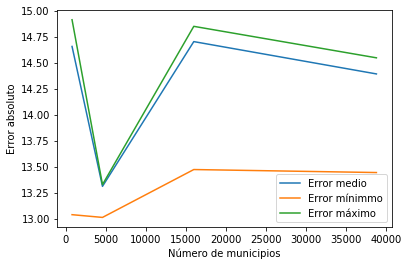

In [109]:
import matplotlib.pyplot as plt
plt.plot(x,mean_y, label='Error medio')
plt.plot(x,min_y, label='Error mínimmo')
plt.plot(x,max_y, label='Error máximo')
plt.ylabel('Error absoluto')
plt.xlabel('Número de municipios')
plt.legend()
plt.show()

In [ ]:
# TODO:
# balancear fake por importancia de municipios
# carpetas en drive: datos, code, resultados, memoria